# VGG 16

#### The network structure

>The input of VGG is set to an RGB image of 224x244 size. The average RGB value is calculated for all images on the training set image, and then the image is input as an input to the VGG convolution network. A 3x3 or 1x1 filter is used, and the convolution step is fixed. . There are 3 VGG fully connected layers, which can vary from VGG11 to VGG19 according to the total number of convolutional layers + fully connected layers. The minimum VGG11 has 8 convolutional layers and 3 fully connected layers. The maximum VGG19 has 16 convolutional layers. +3 fully connected layers. In addition, the VGG network is not followed by a pooling layer behind each convolutional layer, or a total of 5 pooling layers distributed under different convolutional layers. The following figure is VGG Structure diagram:

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" />

In [70]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings

# 1. Loading Images

In [71]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [72]:
training_set = train_datagen.flow_from_directory(r'C:\Users\roshan.gupta\Downloads\Family\train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 subset="training",
                                                 class_mode = 'categorical')

validation_set = train_datagen.flow_from_directory(r'C:\Users\roshan.gupta\Downloads\Family\train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                subset="validation",
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'C:\Users\roshan.gupta\Downloads\Family\test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

#color_mode = "grayscale"

Found 70 images belonging to 10 classes.
Found 10 images belonging to 10 classes.
Found 80 images belonging to 10 classes.


In [73]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
STEP_SIZE_VALID=validation_set.n//validation_set.batch_size
STEP_SIZE_TEST=test_set.n//test_set.batch_size

## 1. Building Model

### 1.1 Implementation with VGG 16 using transfer learning

In [74]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [75]:
IMAGE_SIZE = [224, 224]

In [76]:
#Give dataset path
train_path = r'C:\Users\roshan.gupta\Downloads\Family\train'
test_path = r'C:\Users\roshan.gupta\Downloads\Family\test'

In [77]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [78]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [79]:
# useful for getting number of classes
folders = glob(r'C:\Users\roshan.gupta\Downloads\Family\train\*')
print(len(folders))

12


In [80]:
x = Flatten()(vgg.output)
prediction = Dense(10, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [81]:
from keras import optimizers

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

In [82]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

#lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

#num_epochs = 1000
#num_batch_size = 32

checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=1, save_best_only=True)

callbacks = [checkpoint, lr_reducer]

start = datetime.now()

history = model.fit_generator(training_set, 
                    steps_per_epoch=STEP_SIZE_TRAIN, 
                    epochs = 18, verbose=5, 
                    validation_data = validation_set, 
                    validation_steps = STEP_SIZE_VALID)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/18
Epoch 2/18
Epoch 3/18
Epoch 4/18
Epoch 5/18
Epoch 6/18
Epoch 7/18
Epoch 8/18
Epoch 9/18
Epoch 10/18
Epoch 11/18
Epoch 12/18
Epoch 13/18
Epoch 14/18
Epoch 15/18
Epoch 16/18
Epoch 17/18
Epoch 18/18
Training completed in time:  0:09:51.027545


In [83]:
score = model.evaluate(test_set)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 25s 3s/step
Test Loss: 0.013271725736558437
Test accuracy: 0.9912500381469727


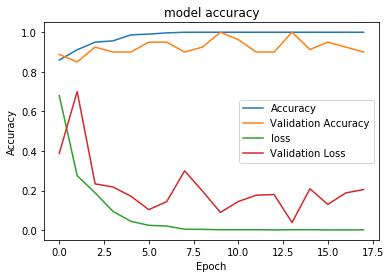

In [91]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [62]:
from keras.models import load_model

model.save('vgg16_model.h5')

In [68]:
model = load_model('vgg16_model.h5')

## Making Prediction

In [67]:
# Part 3 - Making new predictions
import numpy as np
from keras.preprocessing import image
test_image = image.load_img(r'C:\Users\roshan.gupta\Downloads\Family\Test\Roshan\6.jpg', color_mode ='rgb', 
                            target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices
print(result)
res = np.argmax(result)

dict1 = {0 : 'Bush', 1: 'Cats', 2: 'Dogs', 3: 'Hrithik', 4: 'Modi', 5 : 'Obama', 6 : 'Piyush', 7 : 'Roshan', 
         8: 'Salman', 9: 'Shah'}

print("The predicted output is :",dict1[res])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
The predicted output is : Roshan


## Observations :


1. Firstly, we have imported the libraries and did data augmentation using ImageGenerator dataset. 
2. After that we have performed transfer learning of VGG16 model to extract the feature of convolution layer.
3. We have trained our model on fully connected layer for our customized dataset(On train and test dataset).
4. And finally, tested on test data set and we have predicted the class of given image.